# Carvana-DCAN-Three-Classifiers

# Note
Insure uncomment related code lines in models/DCAN.py 

## Imports

In [1]:
from keras.layers.advanced_activations import PReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from optimizers.AdamAccumulate import AdamAccumulate
from models.DCAN import DCAN
from submit import generate_submit
from utilities import utils_contour
from utilities import losses

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


In [2]:
utils_contour.set_results_reproducible()

## Preparing Data

In [3]:
input_size = 128
train_path = "inputs/train/{}.jpg" 
train_mask_path = "inputs/train_masks/{}_mask.gif"
train_contour_path = "inputs/train_contours/{}_contour.jpg"
df_train = pd.read_csv('inputs/train_masks.csv')
ids_train = df_train['img'].map(lambda s: s.split('.')[0])[:3000]
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

print('Training on {} samples'.format(len(ids_train_split)))
print('Validating on {} samples'.format(len(ids_valid_split)))

bboxes = None
bbox_file_path = 'inputs/train_bbox.csv'
bboxes = utils_contour.get_bboxes(bbox_file_path)

def train_generator(batch_size):
    return utils_contour.train_generator(train_path, train_mask_path, train_contour_path, ids_train_split, 
                                 input_size, batch_size, bboxes)

def valid_generator(batch_size):
    return utils_contour.valid_generator(train_path, train_mask_path, train_contour_path, ids_valid_split, 
                                 input_size, batch_size, bboxes)

Training on 2400 samples
Validating on 600 samples


### Some Verifications

In [4]:
x = next(train_generator(2))

In [5]:
#im = x[0][0]
cont = np.reshape(x[1]['contour_out'][0], (128, 128))
cont.shape

(128, 128)

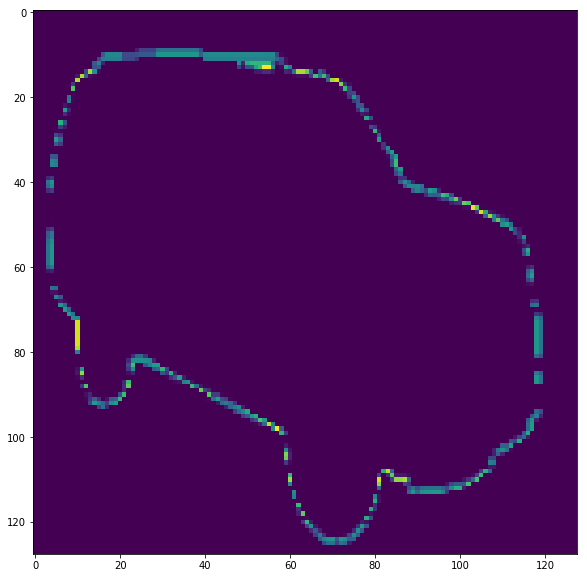

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(cont)

## Create Model

In [7]:
#DCAN:
model = DCAN((input_size, input_size, 3), filters=64, depth=4, dropout_base_only=False, dropout=0,
             activation=lambda x: PReLU()(x), init='he_uniform')

model.compile(optimizer=AdamAccumulate(accum_iters=1), 
              loss={'seg_out': losses.weighted_bce_dice_loss, 'contour_out': losses.contour_weighted_bce_loss,
                    'final_seg': losses.weighted_bce_dice_loss}, 
              loss_weights={'seg_out': 1., 'contour_out': 1.},
              metrics={'seg_out': losses.dice_value, 'contour_out': 'binary_accuracy', 
                       'final_seg': losses.dice_value})

#model.summary()

## Fit Model

In [8]:
epochs = 100
batch_size = 8
run_name = utils_contour.get_run_name('weights/{}.hdf5', 'DCAN')
weights_path = 'weights/{}.hdf5'.format(run_name)

callbacks = [EarlyStopping(monitor='val_final_seg_dice_value',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_final_seg_dice_value',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_final_seg_dice_value',
                             filepath=weights_path,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max'),
             TensorBoard(log_dir='logs/{}'.format(run_name), batch_size=batch_size)]

#model.load_weights('weights/unet-2017-09-02-0322.hdf5')
#K.set_value(model.optimizer.lr, 0.01)

print('Starting run "{}"'.format(run_name))
model.fit_generator(generator=train_generator(batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(batch_size)),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_generator(batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(batch_size)))

Starting run "DCAN-2017-09-11-1453"
Epoch 1/100
300/300 [==============================] - 176s - loss: 0.7316 - seg_out_loss: 0.2335 - contour_out_loss: 0.2683 - final_seg_loss: 0.2298 - seg_out_dice_value: 0.9517 - contour_out_binary_accuracy: 0.9166 - final_seg_dice_value: 0.9563 - val_loss: 0.5595 - val_seg_out_loss: 0.2193 - val_contour_out_loss: 0.1354 - val_final_seg_loss: 0.2048 - val_seg_out_dice_value: 0.9638 - val_contour_out_binary_accuracy: 0.9600 - val_final_seg_dice_value: 0.9663
Epoch 2/100
300/300 [==============================] - 171s - loss: 0.3105 - seg_out_loss: 0.1184 - contour_out_loss: 0.0761 - final_seg_loss: 0.1159 - seg_out_dice_value: 0.9809 - contour_out_binary_accuracy: 0.9517 - final_seg_dice_value: 0.9819 - val_loss: 0.2791 - val_seg_out_loss: 0.1019 - val_contour_out_loss: 0.0800 - val_final_seg_loss: 0.0973 - val_seg_out_dice_value: 0.9822 - val_contour_out_binary_accuracy: 0.9608 - val_final_seg_dice_value: 0.9831
Epoch 3/100
300/300 [===============

300/300 [==============================] - 171s - loss: 0.1652 - seg_out_loss: 0.0632 - contour_out_loss: 0.0416 - final_seg_loss: 0.0604 - seg_out_dice_value: 0.9905 - contour_out_binary_accuracy: 0.9541 - final_seg_dice_value: 0.9910 - val_loss: 0.1738 - val_seg_out_loss: 0.0626 - val_contour_out_loss: 0.0536 - val_final_seg_loss: 0.0577 - val_seg_out_dice_value: 0.9894 - val_contour_out_binary_accuracy: 0.9624 - val_final_seg_dice_value: 0.9904
Epoch 36/100
300/300 [==============================] - 172s - loss: 0.1396 - seg_out_loss: 0.0520 - contour_out_loss: 0.0372 - final_seg_loss: 0.0504 - seg_out_dice_value: 0.9924 - contour_out_binary_accuracy: 0.9547 - final_seg_dice_value: 0.9926 - val_loss: 0.1210 - val_seg_out_loss: 0.0402 - val_contour_out_loss: 0.0419 - val_final_seg_loss: 0.0389 - val_seg_out_dice_value: 0.9942 - val_contour_out_binary_accuracy: 0.9632 - val_final_seg_dice_value: 0.9944
Epoch 37/100
300/300 [==============================] - 172s - loss: 0.1339 - seg_o

299/300 [============================>.] - ETA: 0s - loss: 0.1230 - seg_out_loss: 0.0455 - contour_out_loss: 0.0332 - final_seg_loss: 0.0443 - seg_out_dice_value: 0.9934 - contour_out_binary_accuracy: 0.9553 - final_seg_dice_value: 0.9936
Epoch 00051: reducing learning rate to 1.00000006569e-06.
300/300 [==============================] - 172s - loss: 0.1230 - seg_out_loss: 0.0455 - contour_out_loss: 0.0332 - final_seg_loss: 0.0443 - seg_out_dice_value: 0.9934 - contour_out_binary_accuracy: 0.9553 - final_seg_dice_value: 0.9936 - val_loss: 0.1148 - val_seg_out_loss: 0.0376 - val_contour_out_loss: 0.0404 - val_final_seg_loss: 0.0368 - val_seg_out_dice_value: 0.9948 - val_contour_out_binary_accuracy: 0.9636 - val_final_seg_dice_value: 0.9950
Epoch 53/100
300/300 [==============================] - 171s - loss: 0.1240 - seg_out_loss: 0.0460 - contour_out_loss: 0.0333 - final_seg_loss: 0.0448 - seg_out_dice_value: 0.9933 - contour_out_binary_accuracy: 0.9551 - final_seg_dice_value: 0.9935 - 

## Validation

In [5]:
def np_dice_value(y_true, y_pred):
    smooth = 1.
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

### Prediction

In [6]:
run_name = 'unet-2017-09-03-1739'
model.load_weights('weights/{}.hdf5'.format(run_name))

val_imgs, val_masks = next(valid_generator(len(ids_valid_split)))
val_imgs = np.array(val_imgs)
val_masks = np.array(val_masks)
val_pred_masks = model.predict(val_imgs, batch_size=1)
masks_val_dices = [np_dice_value(mask, pred_mask) for (mask, pred_mask) in zip(val_masks, val_pred_masks)]

### Display the worst predicted mask for validation examples

2faf504842df_09 0.99134050897


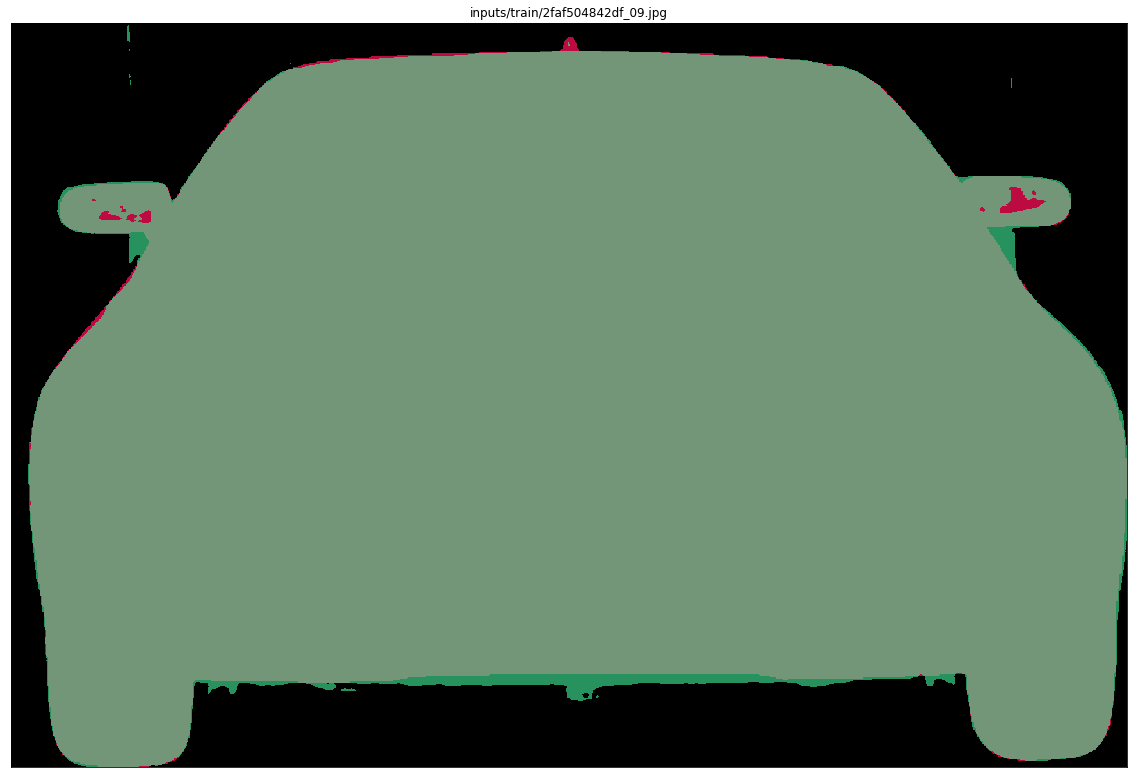

In [20]:
index = np.argsort(masks_val_dices)[0]
id = ids_valid_split.values[index]
utils.show_mask(train_path.format(id), val_masks[index].squeeze(), val_pred_masks[index].squeeze(), show_img=False)
print id, masks_val_dices[index]

### Histogram

In [ ]:
hist, bins = np.histogram(masks_val_dices, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

### Visualization

In [ ]:
indices = np.random.randint(len(ids_valid_split), size=3)
for index in indices:
    id = ids_valid_split.values[index]
    utils.show_mask(train_path.format(id), val_masks[index].squeeze(), val_pred_masks[index].squeeze(),
                    show_img=True, bbox = bboxes[id])

## Test

### Load Model

In [ ]:
# Create model first if required
run_name = 'unet-2017-08-20-5'
model.load_weights('weights/{}.hdf5'.format(run_name))

### Generate Submit

In [ ]:
batch_size = 16
threshold = 0.5
test_path = 'inputs/test1/' #'inputs/test/'
test_masks_path = 'outputs/test1_masks/' #None
generate_submit(model, input_size, batch_size, threshold, test_path, 'outputs/', run_name, test_masks_path)

### Visualization

In [ ]:
utils.show_test_masks(test_path, test_masks_path)